In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Make initial model

In [5]:
with open("/home/sultan/recipes/exploratory_search-variant2_success.yml", "r") as f:
    yaml_string = f.read()

DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"
specific_topics = [f'topic_{i}' for i in range(35)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality1='@word',
    modality2='@post_tag',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described in the article
# Multi-objective Topic Modeling for Exploratory Search in Tech News
# by Anastasya Yanina, Lev Golitsyn and Konstantin Vorontsov, Jan 2018


# Use .format(modality=modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, in the actuall article 200 topics were found to be optimal
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34']
    background_topics: ['bcg_35']

regularizers:
- DecorrelatorPhiRegularizer:


### Define Topic Model

In [6]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./ExploratoryResearchDemo2') == True:
    os.system("rm -rf ./ExploratoryResearchDemo2")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='ExploratoryResearchDemo2',
    save_path='ExploratoryResearchDemo2',
)

In [7]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)
/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Max progression length exceeded
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7f3c6df846d8>}

In [8]:
experiment.show()

Experiment ExploratoryResearchDemo2

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##18h56m18s_18d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──────┤
                                ├##18h56m29s_18d11m2019y###
                                │                                                                                                       ┌##18h56m59s_18d11m2019y###
                                └##18h56m41s_18d11m2019y###─────────────────────────────────────────────────────────────────────────────┤
                                                                                                                                        │                                                                                                       ┌##18h57m46s_18d11m2019y###
                                                                                                                                        │                                                         

In [9]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

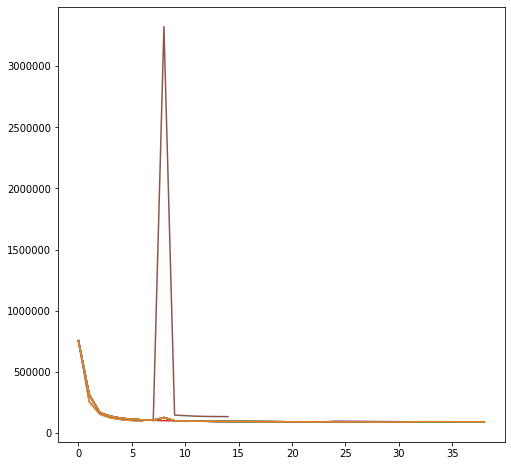

In [10]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.show()

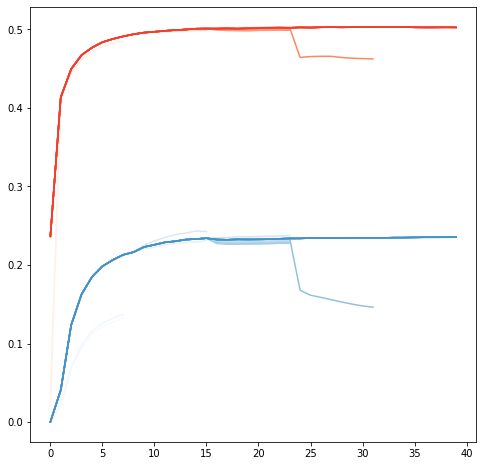

In [11]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [12]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query + " COLLECT all")
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")
for model in models:
    describe_model(model)

smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 1000000.0
sparse_theta -0.5
smooth_phi_@word 0
decorrelation_phi_@post_tag 100000.0
smooth_phi_@post_tag 0
88488.8984375
0.5026137828826904
0.23535428941249847
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 1000000.0
sparse_theta -0.5
smooth_phi_@word 0
decorrelation_phi_@post_tag 100000.0
smooth_phi_@post_tag 0.25
88894.96875
0.502592921257019
0.23534470796585083
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 1000000.0
sparse_theta -0.5
smooth_phi_@word 0
decorrelation_phi_@post_tag 100000.0
smooth_phi_@post_tag 0.5
89290.015625
0.5025845766067505
0.23533648252487183
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 1000000.0
sparse_theta -0.5
smooth_phi_@word 0
decorrelation_phi_@post_tag 100000.0
smooth_phi_@post_tag 0.75
89696.671875
0.5026082992553711
0.23534223437309265
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 1000000.0

### Investigate model

In [13]:
best_model = models[-1]

In [14]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [15]:
thresh = 1e-5
demo_data = Dataset(DATASET_PATH)
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [16]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[-n:]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_29 @post_tag
днк,0.22563
клетка,0.20789
белки,0.10887
рнк,0.06533
клеточная_биология,0.04748
мутация,0.03549
вирус,0.02866
белок,0.02763
инквизиция,0.02688
мембрана,0.01582


репликация днк

внутренний космос

зонд на основе днк измеряет силу между клеткой и поверхностью

центральная догма молекулярной биологии

цитоскелет клеток

биогенез ядерных телец

необычные формы днк

структурная роль некодирующих рнк

регионы-организаторы эмбриона

выдвинута новая гипотеза происхождения эукариотической клетки

,topic_30 @post_tag
политика,0.24806
государство,0.21408
политология,0.12298
демократия,0.0381
либерализм,0.03801
идеология,0.03379
глобализация,0.02914
теория_игр,0.02695
политический_режим,0.02665
культурная_политика,0.02099


государство в теории международных отношений

национальное государство

республиканизм и свобода

либерализм в теории международных отношений

главыискаженная демократия

русский анархизм

faqреспубликанизм и свобода

либеральная традиция в политической мысли

выборы президента сша

мнения избирателей и платформы партий

,topic_31 @post_tag
история_науки,0.11834
мифология,0.11329
древняя_греция,0.08242
античность,0.08236
миф,0.07977
кант_иммануил,0.07193
аристотель,0.06428
платон,0.06176
сократ,0.03088
немецкая_классическая_философия,0.0308


эрос в античной культуре

faqэрос в античной культуре

немецкая классическая философия как понятие

древнегреческие мифы о душе

faqнемецкая классическая философия как понятие

политическая философия эроса

логика мифа

категория пространства в мифе

faqлогика мифа

экономические взгляды сократа

,topic_32 @post_tag
право,0.21733
политическая_философия,0.11109
юриспруденция,0.1062
римское_право,0.07839
власть,0.07806
рим,0.06559
социология_права,0.04044
история_права,0.03789
судопроизводство,0.02275
политическая_теория,0.02256


лица

обязательства

римское право

купля-продажа

контракты

европейская традиция частного права

сервитуты

приобретательная давность

залог

владение

,topic_33 @post_tag
физика,0.45792
квантовая_физика,0.06931
атом,0.04921
квантовая_механика,0.03757
магнитное_поле,0.03512
электрон,0.03396
фотоны,0.03167
квантовые_технологии,0.02937
оптика,0.02585
лазер,0.0235


диалогиуправление светом с помощью плазмонов

гигантское магнетосопротивление

магнитная динамика наносистем

квантовый компьютер

аттосекундная физика

перераспределительное лазерное охлаждение

квантовые интерфейсы

спинтроника

у атомов обнаружили суперпозицию траекторий движения

лазерное детектирование радиоволн

,topic_34 @post_tag
история,0.59092
история_россии,0.11548
ссср,0.09634
русь,0.02768
историография,0.02325
сталин_иосиф,0.02011
терроризм,0.00972
екатерина_ii,0.00945
рюриковичи,0.00844
великая_отечественная_война,0.00842


кризис на рубеже первой и второй пятилеток

эпоха ярослава мудрого

лжедмитрий i

большой террор

ледовое побоище

главыавторские тексты сталина

повесть временных лет

коллективизация

переписка ивана грозного с андреем курбским

«сталин, коба и сосо. молодой сталин в исторических источниках»

,bcg_35 @post_tag
культура,0.59069
общество,0.31058
культурология,0.03659
медиа,0.01904
психоанализ,0.01521
фрейд_зигмунд,0.01063
библиотека,0.00852
культурсоциология,0.00486
режиссура,0.00388
,bcg_35 @word


экономика обмана

трансформация детства

как новые медиа изменили наш мир?

какой должна быть современная библиотека?

почему в россии мало изданий о популярной культуре?

городское пространство в цифровую эпоху

историческая травма как культурное явление

культура справедливости

институт варбурга

универсализм прав человека

In [17]:
print(doc_id)

2829.txt


In [18]:
from topicnet.viewers import TopSimilarDocumentsViewer

In [19]:
tsdv = TopSimilarDocumentsViewer(best_model, dataset)

In [20]:
search_doc = '3384.txt'
print(dataset.get_source_document(search_doc)['raw_text'].values)
sim_docs, scores = tsdv.view(
    search_doc,
    metric='euclidean',
    num_top_similar=10)
for doc_id in sim_docs:
    document = dataset.get_source_document(doc_id)
    doc_title = document.index.values[0]
    doc_snippet = '.'.join(document['raw_text'].values[0].split('.')[:3])
    display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

['@title Феномен внезапности во Второй мировой войне | @snippet Историк Алексей Киличенков о геополитической ситуации накануне Второй мировой, польской разведке и авантюризме Гитлера\n']


3172.txt @title Русская эмиграция и Вторая мировая война | @snippet Историк Олег Будницкий о движении Сопротивления, коллаборационистах и издательской деятельности русских эмигрантов

263.txt @title Автограф # «Свитки из пепла. Еврейская “зондеркоммандо” в Аушвице-Биркенау и ее летописцы» | @snippet Историк Павел Полян о главных документах Холокоста, членах зондеркоманды и осмыслении опыта концентрационных лагерей

2414.txt @title Первая мировая война как война нового типа | @snippet Историк Илья Женин о новых типах оружия, отступлении российской армии и демистификации смерти

836.txt @title Последствия Первой мировой войны | @snippet Историк Илья Женин о последних годах войны, Версальском мирном договоре и судьбе союзников Германии

2426.txt @title Россия в контексте консервативной революции | @snippet Историк Илья Женин о понимании России через литературу, очищении большевистской революцией и Петербурге как декорации

1032.txt @title «Зондеркоммандо» | @snippet Историк Павел Полян о лагерях смерти, зондеркоманде Аушвица и документах Холокоста

2315.txt @title FAQ: Изобретение культурной политики | @snippet 7 фактов о первом министерстве культуры, политике СССР и мультикультурализме

2061.txt @title Патриотическая риторика в годы Гражданской войны | @snippet Историк Людмила Новикова об антибольшевистском лагере, красной пропаганде и мифе об интервенции

2656.txt @title Советская Бавария | @snippet Историк Александр Ватлин о феномене Второй Советской Баварской республики, мюнхенских коммунарах и военной пропаганде в мирное время

3233.txt @title Папство и Россия: история дипломатических отношений | @snippet Как развивались отношения Москвы и Святого Престола и с какими проблемами им приходилось сталкиваться?